In [1]:
%load_ext autoreload
%autoreload 2

# import cPickle

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

## Setup: Network Weights and State Computer

In [2]:
# Load the network

from network import NetworkType, Network

ix2char = np.load('./data/lk_ix2char.npy', encoding='latin1').item()  # i am suspicious about this encoding thing
map_chr_2_ind = {v: k for k, v in ix2char.items()}

lstm_net = Network(NetworkType.LSTM, input_dim=len(map_chr_2_ind))

lstm_net.set_parameters('./models/seqgen_lstm_512_512_512.pkl')

In [3]:
# Set up state computer

from util import StateComputer

sc = StateComputer(lstm_net.cost_model, map_chr_2_ind)

## Basic facts about cost-matrix output

### First states == initial states

In [4]:
# Something nice to print at each iteration
msg = "Is the <{}> variable equal to its initial value after any random char?\n{}"
model_initial_vals = lstm_net.cost_model.get_parameter_values()
name_converter = {
    'sequencegenerator_cost_matrix_cells':
    '/sequencegenerator/with_fake_attention/transition/layer#0.initial_cells',
    'sequencegenerator_cost_matrix_cells#1':
    '/sequencegenerator/with_fake_attention/transition/layer#1.initial_cells',
    'sequencegenerator_cost_matrix_cells#2':
    '/sequencegenerator/with_fake_attention/transition/layer#2.initial_cells',
    'sequencegenerator_cost_matrix_states':
    '/sequencegenerator/with_fake_attention/transition/layer#0.initial_state',
    'sequencegenerator_cost_matrix_states#1':
    '/sequencegenerator/with_fake_attention/transition/layer#1.initial_state',
    'sequencegenerator_cost_matrix_states#2':
    '/sequencegenerator/with_fake_attention/transition/layer#2.initial_state' 
}
# read every char in vocab
reading_singleton_seqs = [sc.read_single_sequence([char_id]) for char_id in map_chr_2_ind.values()]
for state_name in sc.state_var_names:
    # getting initial value of variable
    initial_val = model_initial_vals[name_converter[state_name]]
    read_vals = [val[state_name] for val in reading_singleton_seqs]
    print(msg.format(state_name, all(np.all(v == initial_val) for v in read_vals)))

Is the <sequencegenerator_cost_matrix_cells> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_cells#1> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_cells#2> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_states> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_states#1> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_states#2> variable equal to its initial value after any random char?
True


### States One Step Behind
At position *t* states/cells reflect input at *t-1*

In [5]:
period_id = map_chr_2_ind['.']
# we vary only the first char in the sequence, the second one stays the same.
bigram_seqs = [(char_id, period_id) for char_id in map_chr_2_ind.values()]
reading_bigrams = [sc.read_single_sequence(bs) for bs in bigram_seqs]
for state_name in sc.state_var_names:
    for pos in (0, 1):
        read_vals = [val[state_name][pos] for val in reading_bigrams]
        print('Are values for <{}> at pos {} equal amongst themselves?'.format(state_name, pos))
        print(np.array_equal(read_vals[1:], read_vals[:-1]))

Are values for <sequencegenerator_cost_matrix_cells> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_cells> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_cells#1> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_cells#1> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_cells#2> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_cells#2> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_states> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_states> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_states#1> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_states#1> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_sta

## Old Demo

In [6]:
aux_var_name = "sequencegenerator_cost_matrix_cells#2"

In [43]:
# demo_sent = "13:2 And Abram was very rich in cattle, in silver, and in gold."
# demo_sent = "16:11 Seek the LORD and his strength, seek his face continually."
# demo_sent = "cats eat mice."
# second_demo_sent = "cats eat flies"
# the problem about this sentence is that I cannot see the difference between end of seq and closing bracket
demo_seqs = ['static void pfn_inject_exit(void)\n{\n        debugfs_remove_recursive(hwpoison_dir);\n}',
            'static int follow_pfn_pte(struct vm_area_struct *vma, unsigned long address,\n                pte_t *pte, unsigned int flags)\n{\n        /* No page to get reference */\n        if (flags & FOLL_GET)\n                return -EFAULT;\n\n        if (flags & FOLL_TOUCH) {\n                pte_t entry = *pte;\n\n                if (flags & FOLL_WRITE)\n                        entry = pte_mkdirty(entry);\n                entry = pte_mkyoung(entry);\n\n                if (!pte_same(*pte, entry)) {\n                        set_pte_at(vma->vm_mm, address, pte, entry);\n                        update_mmu_cache(vma, address, pte);\n                }\n        }\n\n        /* Proper page table entry exists, but no corresponding struct page */\n        return -EEXIST;\n}\n', 
            'if (flags & FOLL_GET) {\n                get_page(page);\n\n                /* drop the pgmap reference now that we hold the page */\n                if (pgmap) {\n                        put_dev_pagemap(pgmap);\n                        pgmap = NULL;\n                }\n        }',
            'if (flags & FOLL_SPLIT) {\n                int ret;\n                page = pmd_page(*pmd);\n                if (is_huge_zero_page(page)) {\n                        spin_unlock(ptl);\n                        ret = 0;\n                        split_huge_pmd(vma, pmd, address);\n                } else {\n                        get_page(page);\n                        spin_unlock(ptl);\n                        lock_page(page);\n                        ret = split_huge_page(page);\n                        unlock_page(page);\n                        put_page(page);\n                }\n\n                return ret ? ERR_PTR(ret) :\n                        follow_page_pte(vma, address, pmd, flags);\n        }']
demo_seq = demo_seqs[3]

In [44]:
demo_computed_vars = sc.read_single_sequence(demo_seq)

In [45]:
demo_cell = demo_computed_vars[aux_var_name]

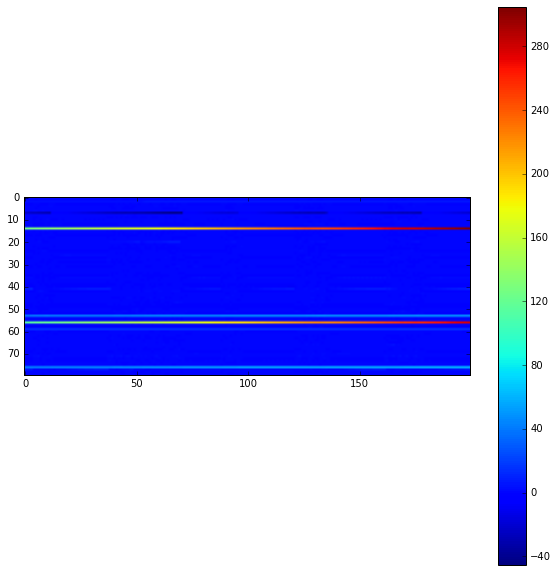

In [47]:
from scipy.misc import imshow as show_image

plt.figure(figsize=(10, 10))
plt.imshow(demo_cell[200:400,100:180].T)
plt.colorbar()

### Hinton Diagrams

In [13]:
from stoogeplot import hinton_diagram

In [ ]:
# inspection cell

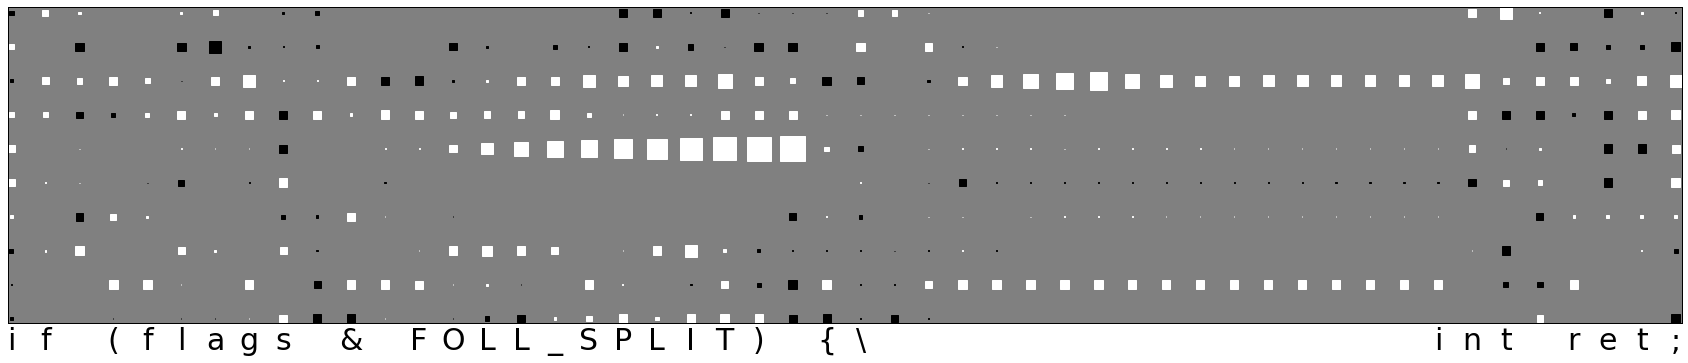

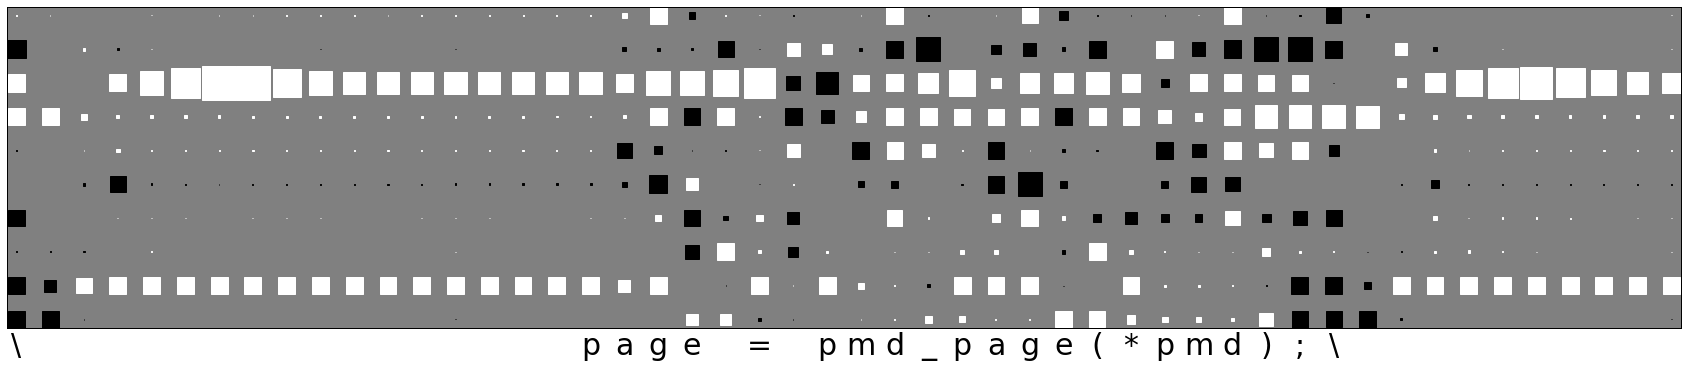

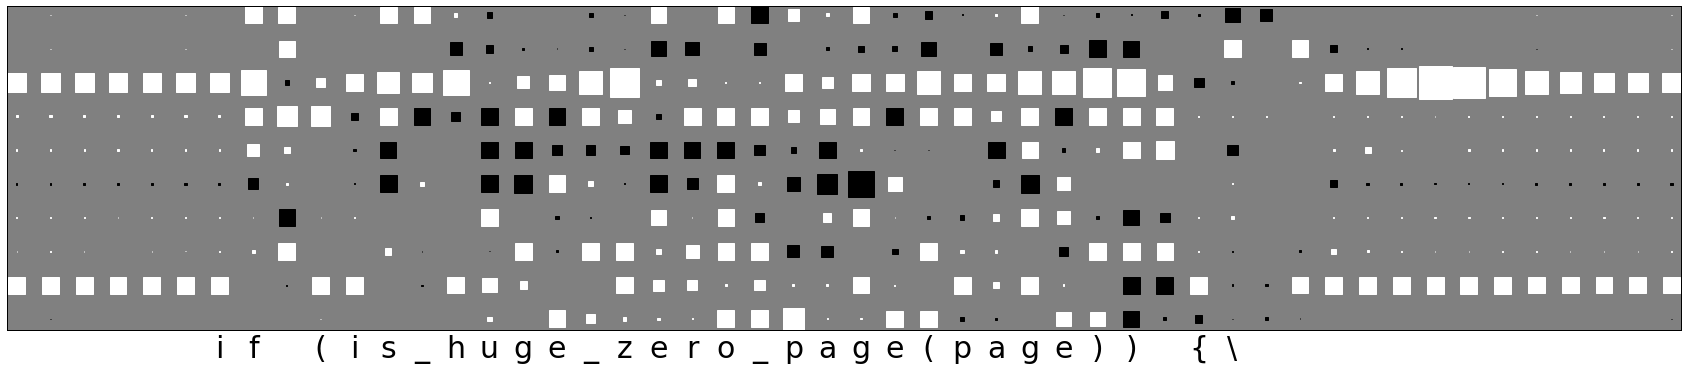

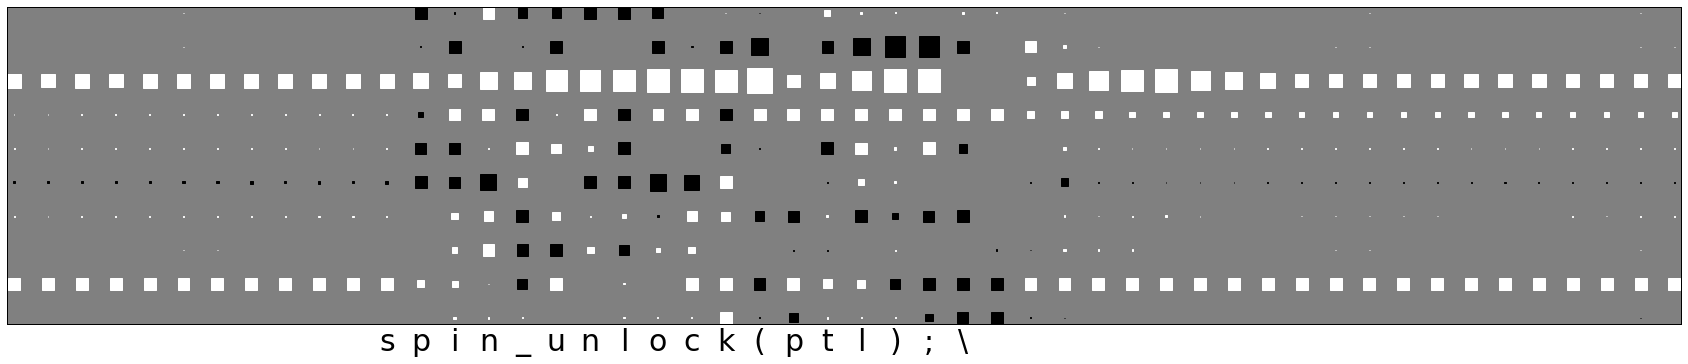

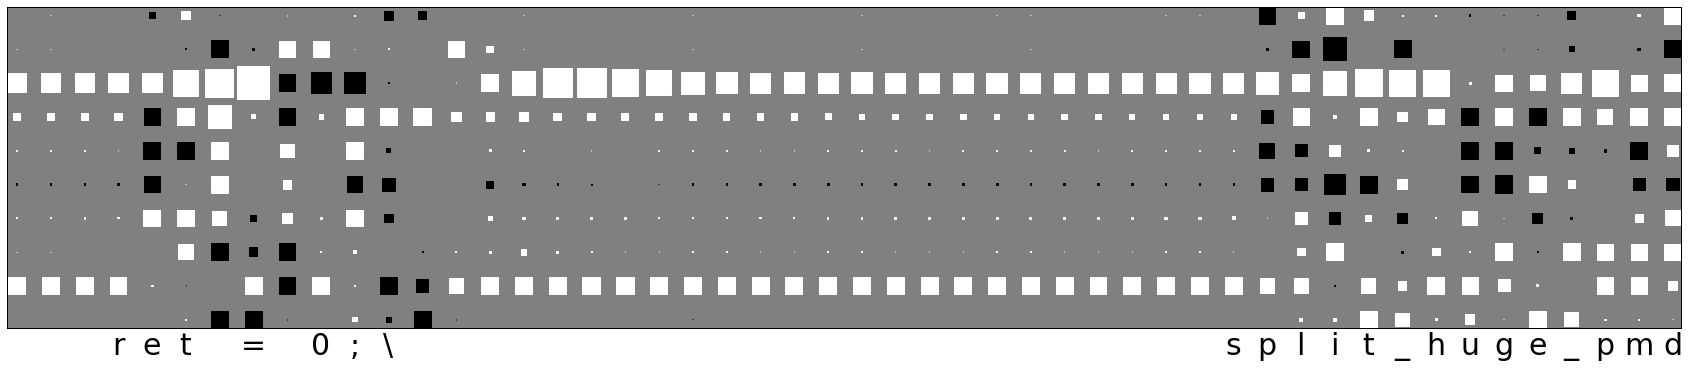

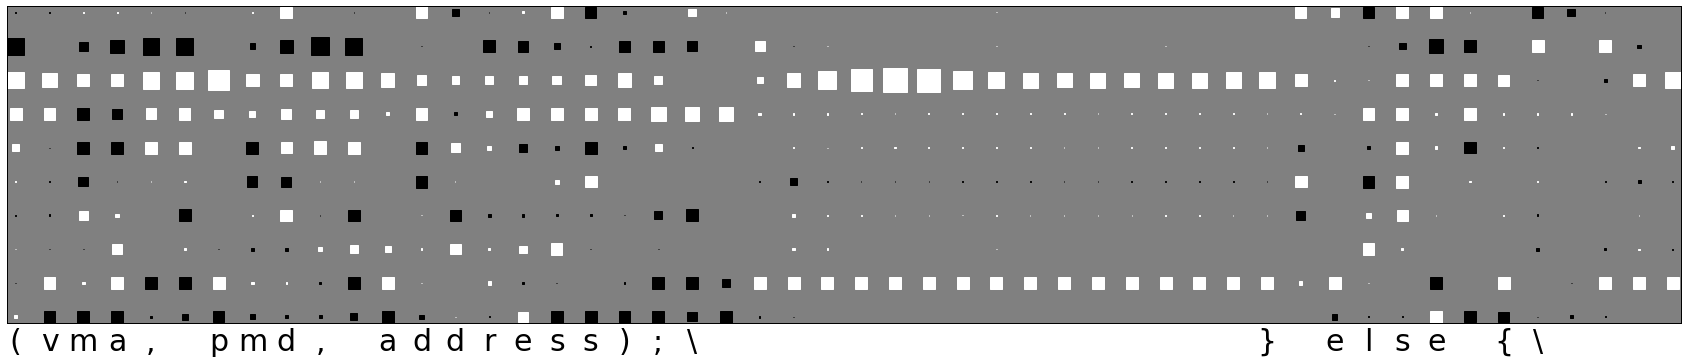

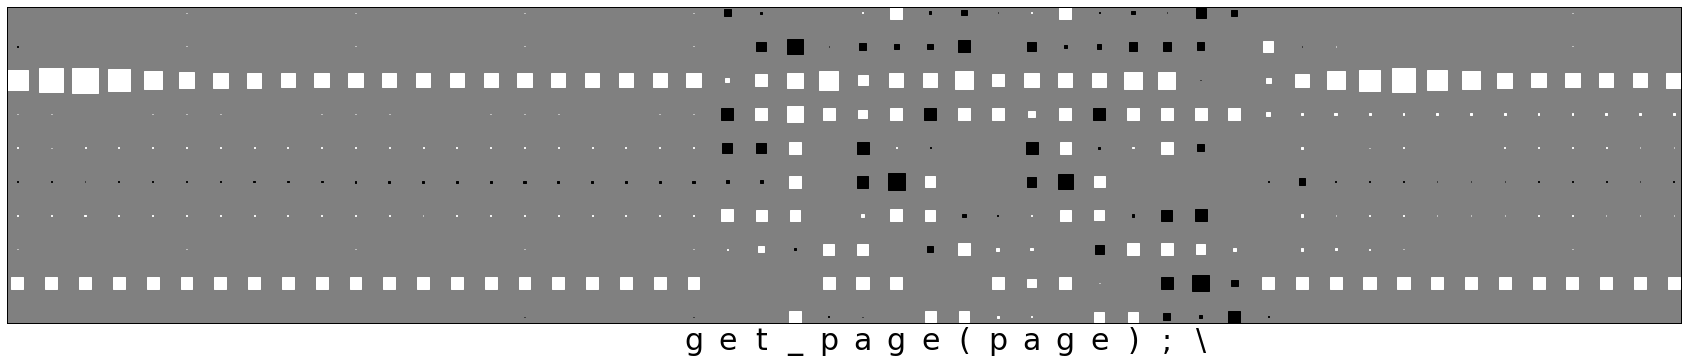

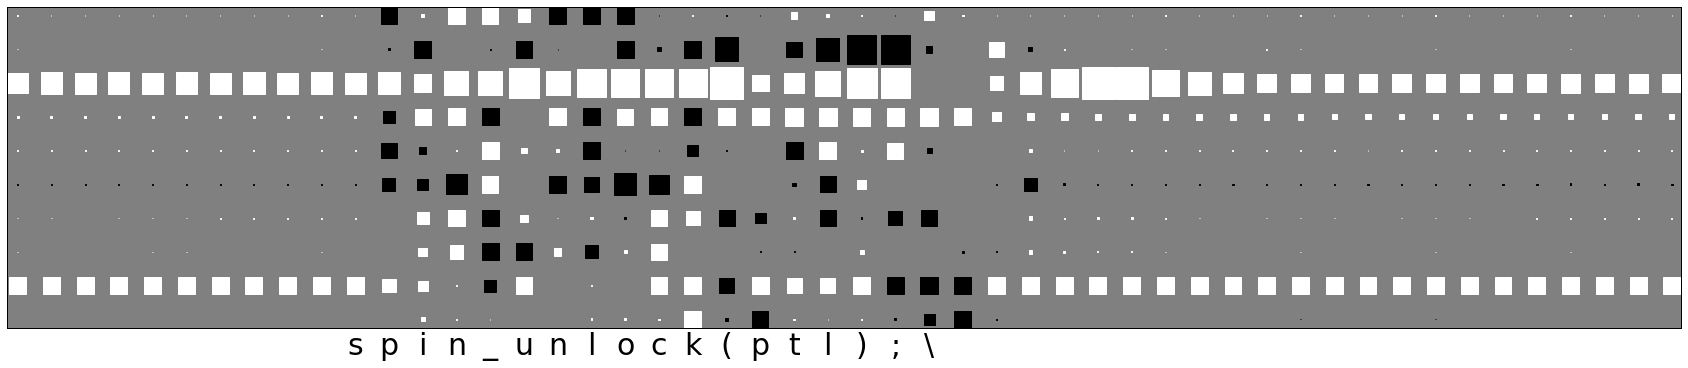

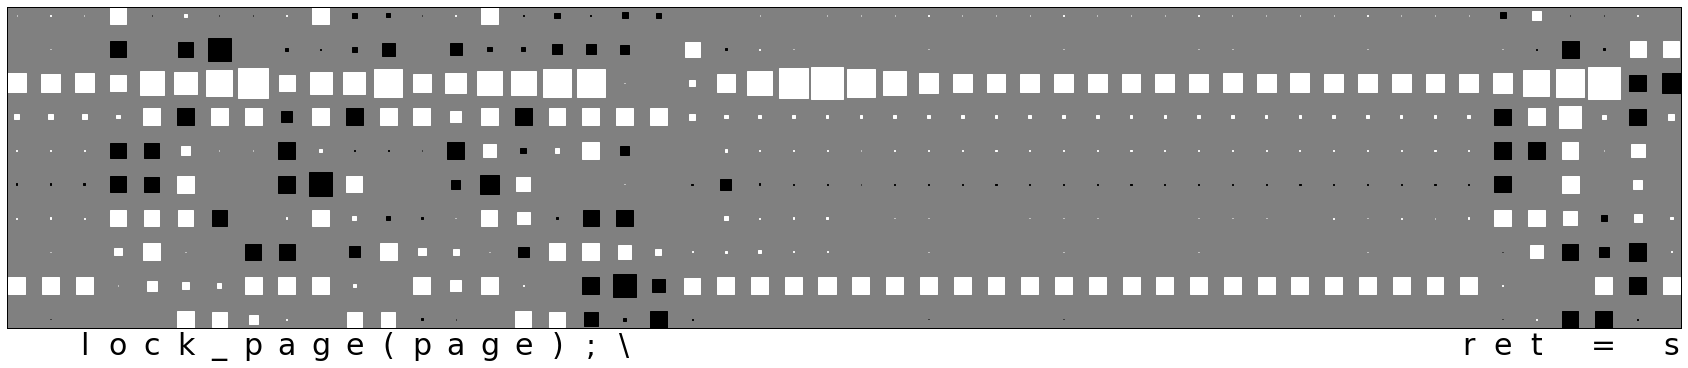

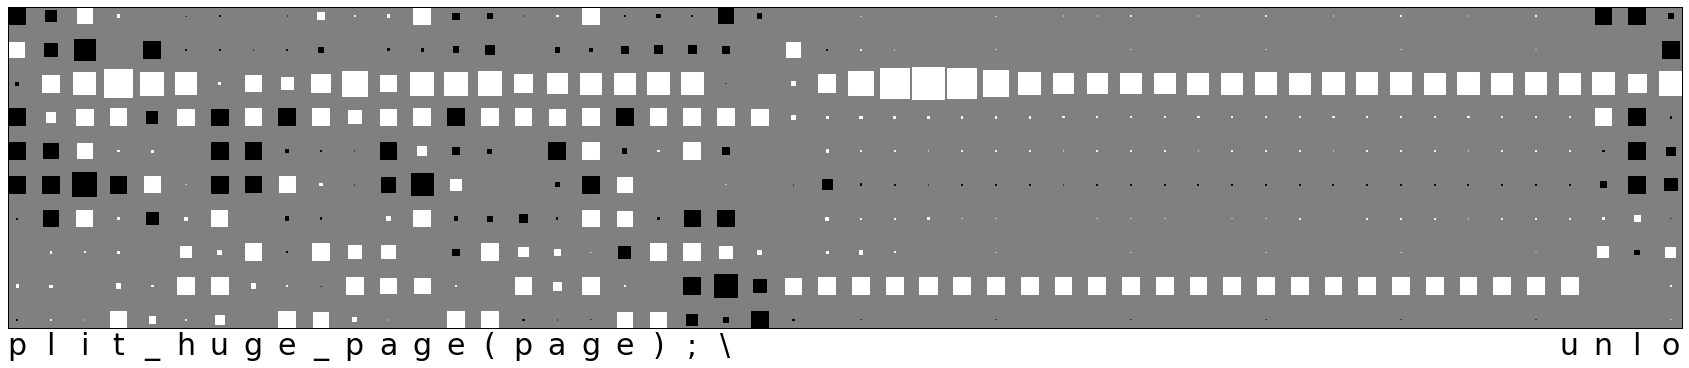

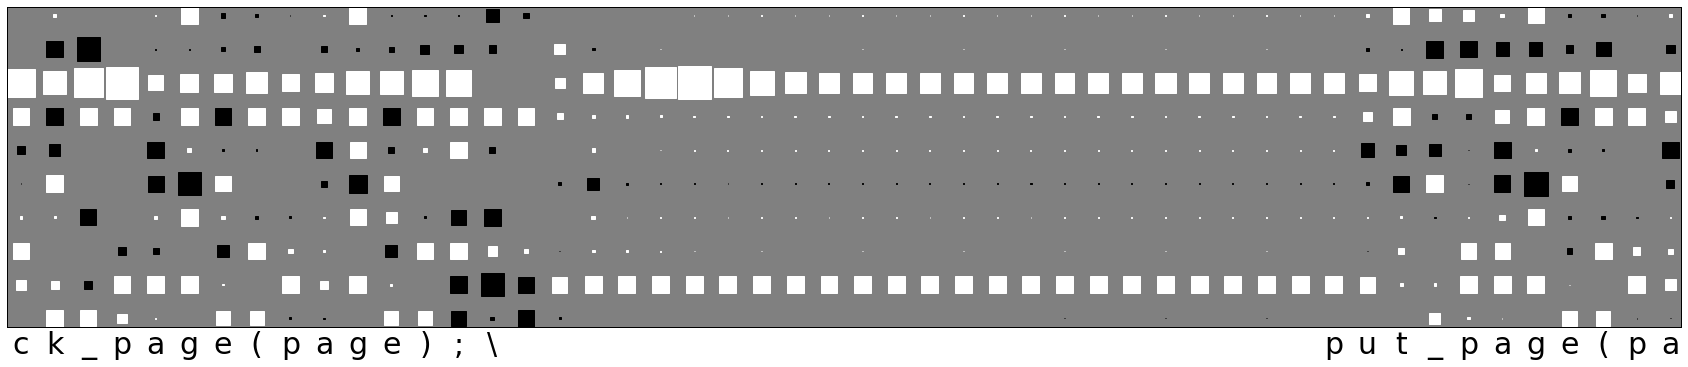

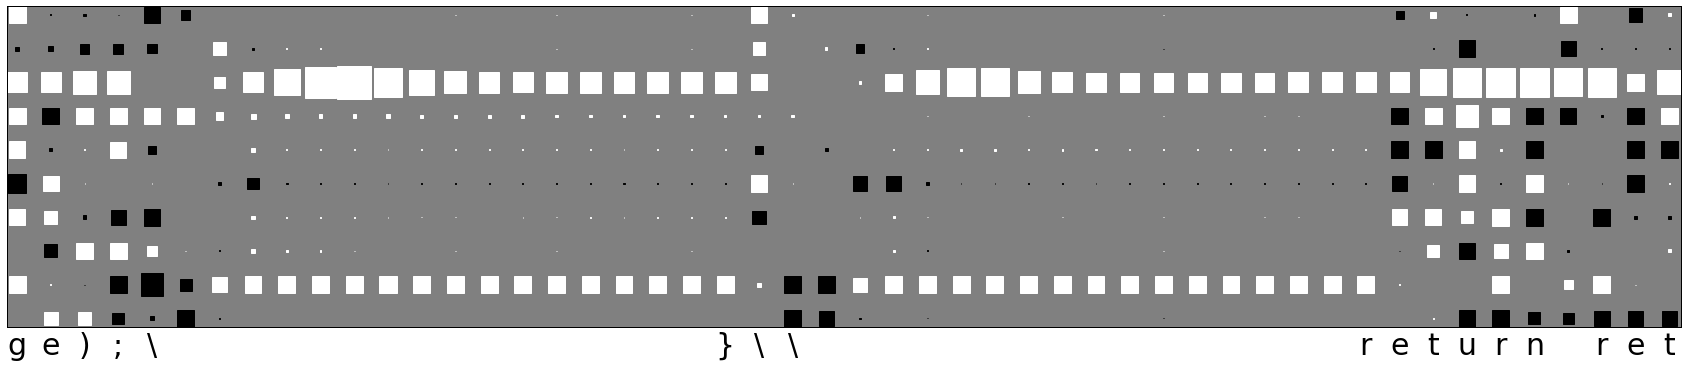

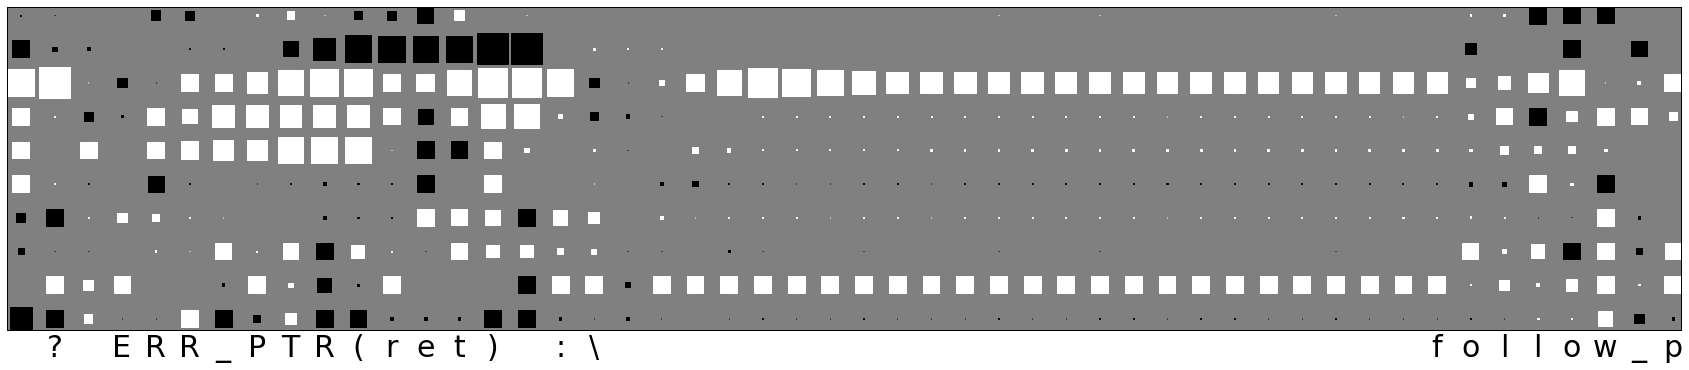

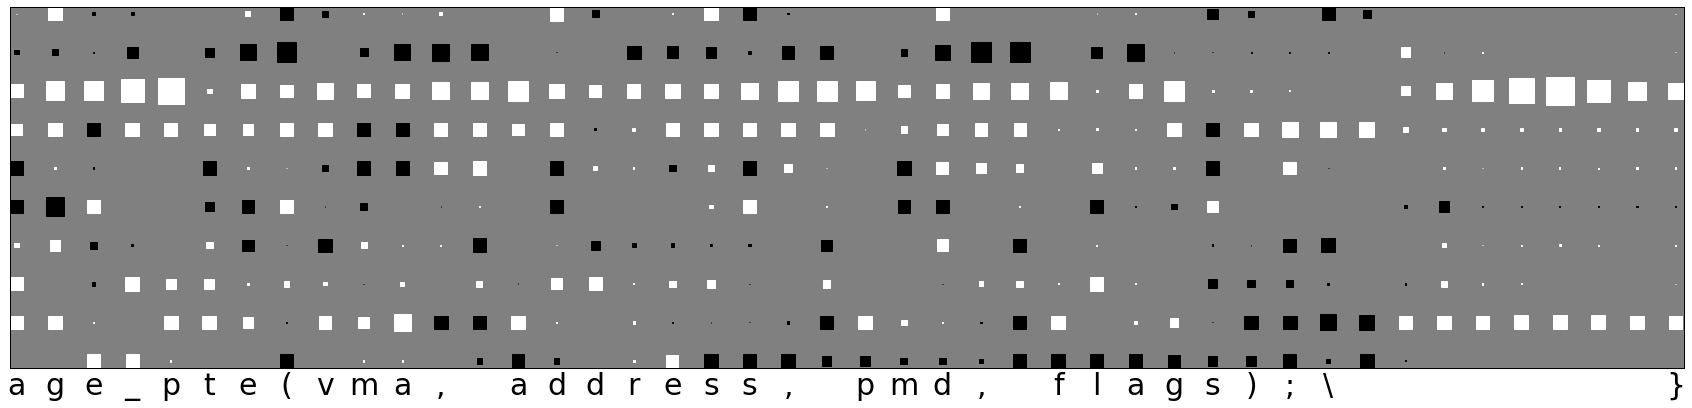

In [52]:
diagrams = []
step = 50
for i in range(0, len(demo_seq), step):
    f = plt.figure(figsize=(30, 50))
    diagrams.append(hinton_diagram(demo_cell[i:i+step,0:10], xticks=demo_seq[i:i+step].replace('\n','\\')))
    f.subplots_adjust(bottom=0.2)
    
# this setup shows more activation for non-spacial text, let's see what model 2 provides :)

In [ ]:
# ranges from 0 to len(input_char_seq) - 1
plt.plot(demo_cell[:,10])
plt.ylabel("Activation")
plt.xlabel("Character Sequence")
# plt.show()

In [ ]:
# Get some example sequence from training data

import h5py

bible = h5py.File("bible.hdf5")

sequence = np.expand_dims(bible['character_seqs'][0], axis=1).T

In [ ]:
# Compute auxiliary variables and select last layer cells

auxiliaries = reader[2](sequence, np.ones((1, 47), dtype='f'))

# To make plotting nicer, swap seqlen and cell size axes
third_cell = auxiliaries[2].swapaxes(0, 2)

In [ ]:
# Verify consistent cell value!
# DON'T run this after the first time
third_cell_old = third_cell

In [ ]:
(third_cell_old == third_cell).all()

### Plotting Stuff...

This for now is just a demo of how easy it is to get at the various components of an NN and plot them

In [ ]:
cats_mice = sc.read_single_sequence("cats eat mice")

In [ ]:
# f = plt.figure(figsize=(20, 20))
# plt.pcolormesh(np.expand_dims(third_cell[0][0], axis=0))
plt.pcolormesh(abram_cell2_simple[:,18:20].T)
# sets char IDs as tick labels on the X axis
# plt.xticks(input_positions, list("cats eat mice"))
# plt.yticks([])
# plt.ylim(0, 0.1)
plt.colorbar()
plt.show()

In [ ]:
plt.pcolormesh(np.random.rand(1, 6))
plt.show()

## ICA

For now not used.

In [ ]:
from sklearn.decomposition import FastICA

ica = FastICA()

# Crashes kernel atm
src = ica.fit_transform(demo_cell)